In [30]:
import pymc as pm
import matplotlib.pyplot as plt
import numpy as np
from pymc.Matplot import plot as mcplot

In [31]:
def stock_loss(y_true: float, y_pred: float, alpha=100.):
    if y_true * y_pred < 0:
        # have opposite signs
        return alpha * y_pred ** 2 + abs(y_pred) + abs(y_true)
    return abs(y_true - y_pred)

Text(0.5, 1.0, 'Stock loss with different true value')

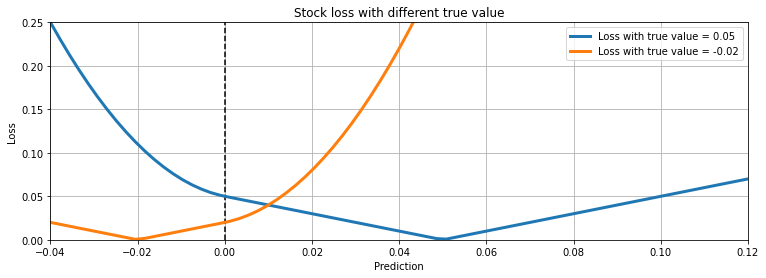

In [32]:
y_preds = np.linspace(-0.04, 0.12, 75)

plt.figure(figsize=(12.5, 4))

for y_true in [0.05, -0.02]:
    loss = [stock_loss(y_true, y_pred) for y_pred in y_preds]
    plt.plot(y_preds, loss, label=f"Loss with true value = {y_true}", lw=3)
plt.vlines(0, 0, 0.25, linestyles="--")
plt.xlabel("Prediction")
plt.ylabel("Loss")
plt.xlim(-0.04, 0.12)
plt.ylim(0, 0.25)
plt.legend()
plt.grid()
plt.title("Stock loss with different true value")

当预测值经过0时，loss曲线有明显变化，这个损失反映了用户并不想猜错符号，尤其是不想大幅度地猜错

## 虚拟数据

The linear fit params: k - 0.5408408566575623, b - 0.0017402903446662728


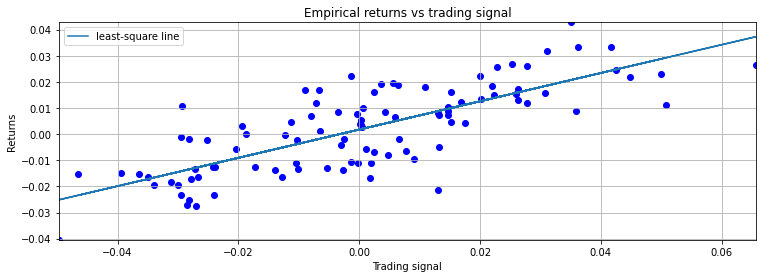

In [44]:
N = 100
X = 0.025 * np.random.randn(N)
Y = 0.5 * X + 0.01 * np.random.randn(N)

ls_coef = np.cov(X, Y)[0, 1] / np.var(X)
ls_intercept = Y.mean() - ls_coef * X.mean()

plt.figure(figsize=(12.5, 4))
plt.scatter(X, Y, c="b")
plt.xlabel("Trading signal")
plt.ylabel("Returns")
plt.title("Empirical returns vs trading signal")
plt.plot(X, ls_coef * X + ls_intercept, label="least-square line")
plt.xlim(X.min(), X.max())
plt.ylim(Y.min(), Y.max())
plt.legend(loc="upper left")
plt.grid()

print(f"The linear fit params: k - {ls_coef}, b - {ls_intercept}")

使用Bayesian回归 $R=\alpha + \beta x + \epsilon$

 [-----------------100%-----------------] 100000 of 100000 complete in 8.0 secPlotting alpha
Plotting std
Plotting beta


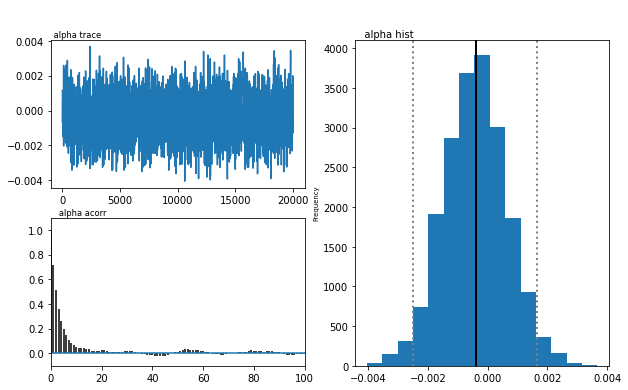

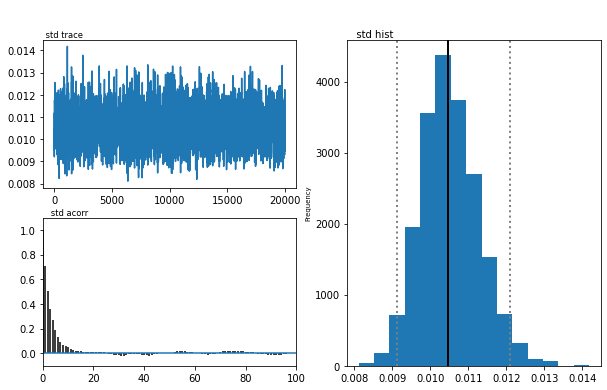

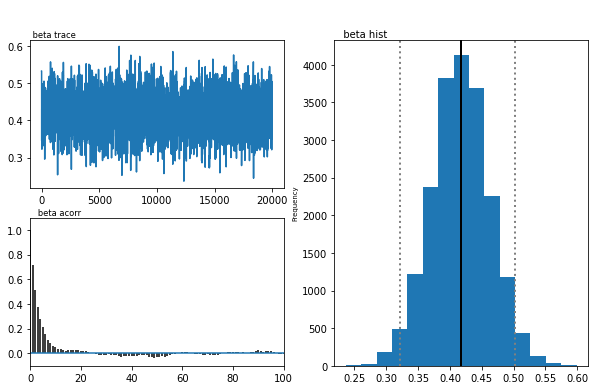

In [39]:
std = pm.Uniform("std", 0, 100)
beta = pm.Normal("beta", 0, 0.0001)
alpha = pm.Normal("alpha", 0, 0.0001)

y_pred = alpha + beta * X
obs = pm.Normal("obs", y_pred, 1.0 / std ** 2, value=Y, observed=True)
mcmc = pm.MCMC([obs, y_pred, alpha, beta, std])
mcmc.sample(1e+5, 8e+4)
mcplot(mcmc)

Beta:  0.41683742821200614
Alpha:  -0.0004103687111091075
Std:  0.010515754462765339


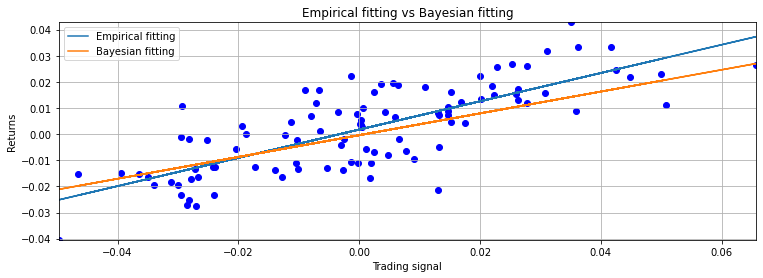

In [46]:
std_samples, alpha_samples, beta_samples = [mcmc.trace(var)[:] for var in ["std", "alpha", "beta"]]
N = len(std_samples)

print("Beta: ", beta_samples.mean())
print("Alpha: ", alpha_samples.mean())
print("Std: ", std_samples.mean())

plt.figure(figsize=(12.5, 4))
plt.scatter(X, Y, c="b")
plt.xlabel("Trading signal")
plt.ylabel("Returns")
plt.title("Empirical fitting vs Bayesian fitting")
plt.xlim(X.min(), X.max())
plt.ylim(Y.min(), Y.max())

plt.plot(X, ls_coef * X + ls_intercept, label="Empirical fitting")
plt.plot(X, beta_samples.mean() * X + alpha_samples.mean(), label="Bayesian fitting")
plt.legend(loc="upper left")
plt.grid()

In [27]:
from scipy.optimize import fmin

In [48]:
def stock_loss(y_true: np.ndarray, y_pred: float, coef=500.):
    result = np.zeros_like(y_true)
    ix = y_true * y_pred < 0
    result[ix] = coef * y_pred ** 2 + abs(y_pred) + np.abs(y_true[ix])
    result[~ix] = np.abs(y_true[~ix] - y_pred)
    return result

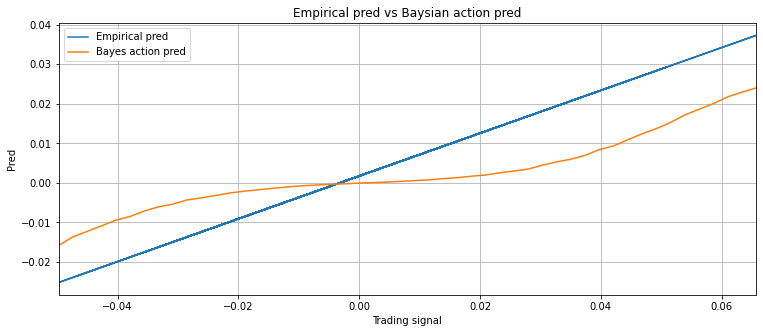

In [49]:
opt_pred = []

# 模拟随机真实值，按照生成参数来生成
possible_outcomes = lambda signal: alpha_samples + beta_samples * signal + std_samples * np.random.randn(N)
trading_signals = np.linspace(X.min(), X.max(), 50)

for _signal in trading_signals:
    _possible_outcomes = possible_outcomes(_signal)  # shape (N,)
    tomin = lambda y_pred: stock_loss(_possible_outcomes, y_pred).mean()
    opt_pred.append(fmin(tomin, 0, disp=False))


plt.figure(figsize=(12.5, 5))
plt.xlabel("Trading signal")
plt.ylabel("Pred")
plt.title("Empirical pred vs Baysian action pred")
plt.plot(X, ls_coef * X + ls_intercept, label="Empirical pred")
plt.plot(trading_signals, opt_pred, label="Bayes action pred")
plt.xlim(X.min(), X.max())
plt.legend(loc="upper left")
plt.grid()

当交易信号接近0时，正负回报都有可能出现，最好是将行动预测判定为0，处于中立。  
  
只有我们都非常自信时，才进场下注。这种风格的模型称作**稀疏预测**，即当我们对不确定性感到不安时，选择不作为。而当信号越来越极端，我们对正负回报的预测越来越自信时，模型会收敛到最小二乘。  
  
稀疏预测模型不是想要千方百计地拟合数据，而是找到针对最小损失的最好预测